
===================== [Random Forest - GPP] =====================
Best Hyperparameters: {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': None, 'max_depth': None}
R² (Coefficient of Determination):   0.9149
RMSE (Root Mean Squared Error):      2.2488
MAE (Mean Absolute Error):           1.2446
ρ (Pearson Correlation Coefficient): 0.9567


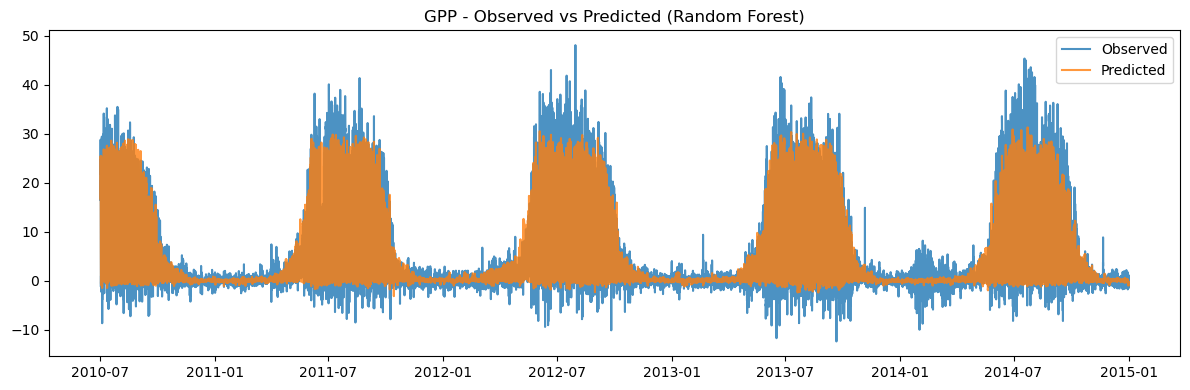

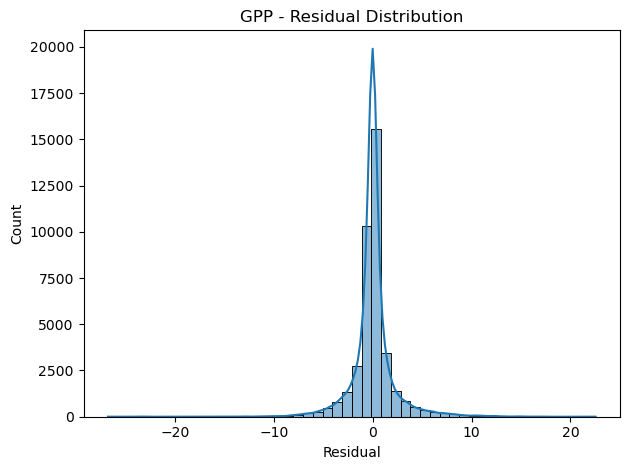

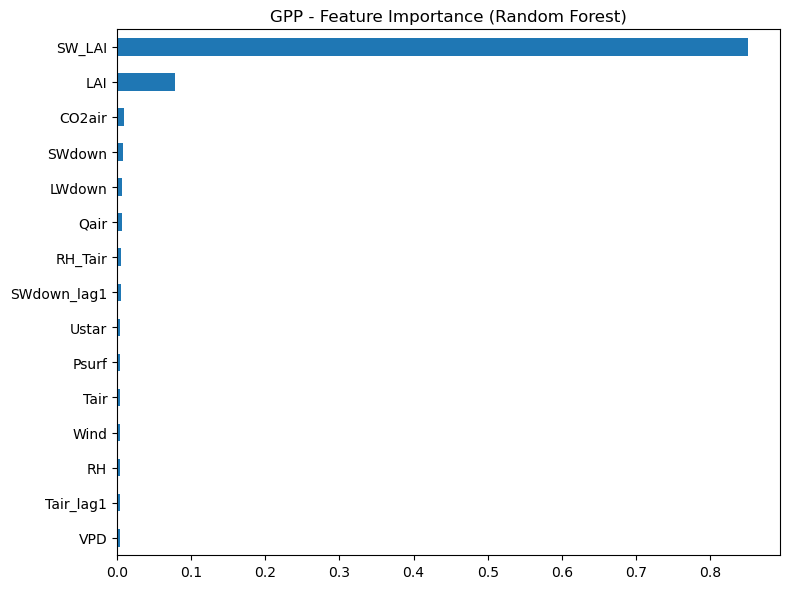

/opt/anaconda3/envs/gpp-model/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(



===================== [Random Forest - NEE] =====================
Best Hyperparameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': None}
R² (Coefficient of Determination):   0.8928
RMSE (Root Mean Squared Error):      2.2053
MAE (Mean Absolute Error):           1.2549
ρ (Pearson Correlation Coefficient): 0.9457


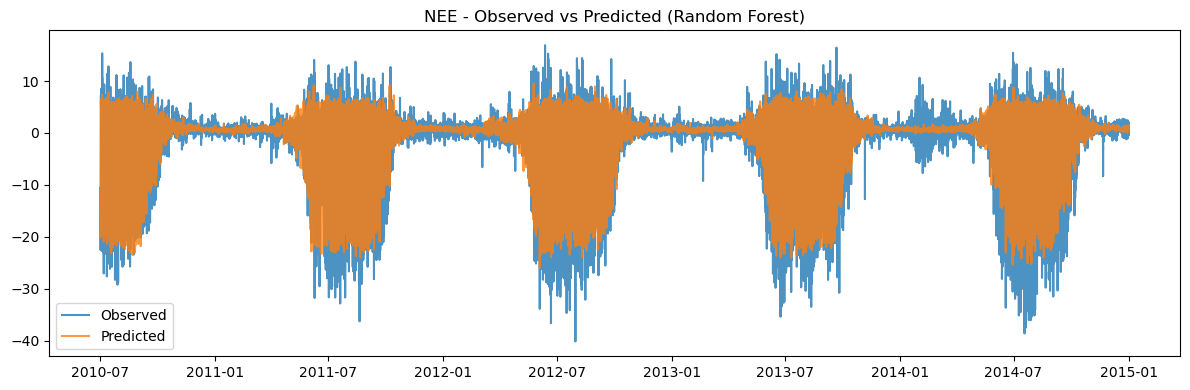

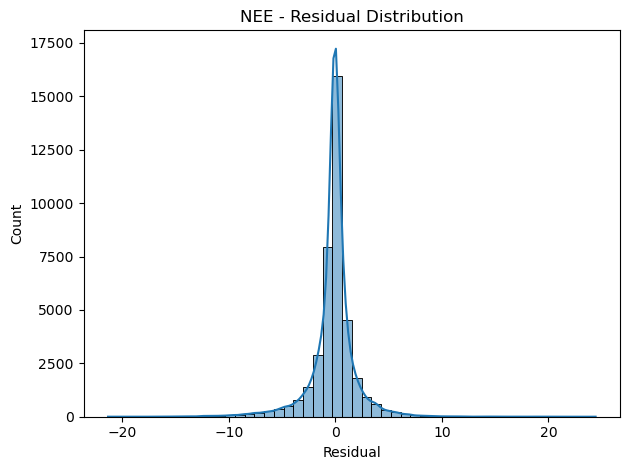

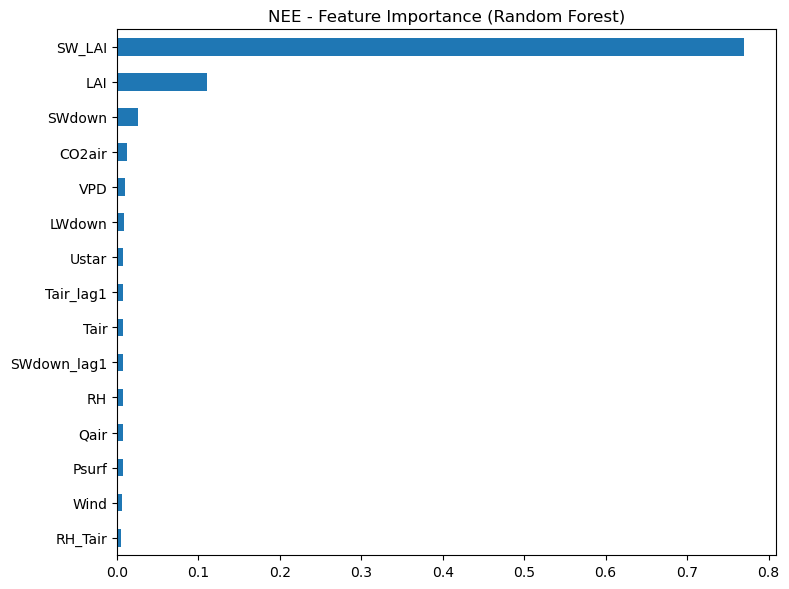

In [11]:
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from scipy.stats import pearsonr

# --------------------- 1. Load & Merge Data ---------------------
met_ds = xr.open_dataset("US-UMB_2000-2014_FLUXNET2015_Met.nc")
flux_ds = xr.open_dataset("US-UMB_2000-2014_FLUXNET2015_Flux.nc")

met_df = met_ds.to_dataframe().reset_index()
flux_df = flux_ds.to_dataframe().reset_index()

df = pd.merge_asof(met_df.sort_values('time'), flux_df.sort_values('time'), on='time')

# 选择特征和目标
features_raw = ['SWdown', 'LWdown', 'Tair', 'Qair', 'RH', 'Psurf', 'Wind',
                'CO2air', 'VPD', 'LAI', 'Ustar']
target_vars = ['GPP', 'NEE']
df = df[['time'] + features_raw + target_vars].dropna()

# --------------------- 2. Feature Engineering ---------------------
df['SW_LAI'] = df['SWdown'] * df['LAI']
df['RH_Tair'] = df['RH'] * df['Tair']
df['SWdown_lag1'] = df['SWdown'].shift(1)
df['Tair_lag1'] = df['Tair'].shift(1)
df = df.dropna()

df = df.set_index('time').sort_index()
features = features_raw + ['SW_LAI', 'RH_Tair', 'SWdown_lag1', 'Tair_lag1']

# --------------------- 3. Train/Test Split ---------------------
split_idx = int(len(df) * 0.7)
train_df = df.iloc[:split_idx]
test_df = df.iloc[split_idx:]

# --------------------- 4. 模型训练函数 ---------------------
def run_rf_model(target_var):
    X_train = train_df[features]
    y_train = train_df[target_var]
    X_test = test_df[features]
    y_test = test_df[target_var]

    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [5, 10, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2', None]
    }

    rf = RandomForestRegressor(random_state=42)
    tscv = TimeSeriesSplit(n_splits=3)
    search = RandomizedSearchCV(rf, param_distributions=param_grid, n_iter=20, cv=tscv, n_jobs=-1, verbose=0)
    search.fit(X_train, y_train)

    best_model = search.best_estimator_
    y_pred = best_model.predict(X_test)

    # 评价指标
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    rho, _ = pearsonr(y_test, y_pred)

    print(f"\n===================== [Random Forest - {target_var}] =====================")
    print(f"Best Hyperparameters: {search.best_params_}")
    print(f"R² (Coefficient of Determination):   {r2:.4f}")
    print(f"RMSE (Root Mean Squared Error):      {rmse:.4f}")
    print(f"MAE (Mean Absolute Error):           {mae:.4f}")
    print(f"ρ (Pearson Correlation Coefficient): {rho:.4f}")

    # 可视化
    plt.figure(figsize=(12, 4))
    plt.plot(y_test.index, y_test.values, label="Observed", alpha=0.8)
    plt.plot(y_test.index, y_pred, label="Predicted", alpha=0.8)
    plt.title(f"{target_var} - Observed vs Predicted (Random Forest)")
    plt.legend()
    plt.tight_layout()
    plt.show()

    sns.histplot(y_test - y_pred, bins=50, kde=True)
    plt.title(f"{target_var} - Residual Distribution")
    plt.xlabel("Residual")
    plt.tight_layout()
    plt.show()

    # 特征重要性
    importances = pd.Series(best_model.feature_importances_, index=features)
    importances.sort_values().plot(kind='barh', figsize=(8, 6))
    plt.title(f"{target_var} - Feature Importance (Random Forest)")
    plt.tight_layout()
    plt.show()

# --------------------- 5. 执行模型（GPP + NEE） ---------------------
run_rf_model("GPP")
run_rf_model("NEE")
